In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_utils import (fetch_sp500_tickers, download_panel_data, 
                            engineer_features, define_regimes)

In [2]:
ticker_map = fetch_sp500_tickers()
panel_df = download_panel_data(ticker_map)

[*********************100%***********************]  55 of 55 completed


In [3]:
panel_df.head()

Price,Date,Ticker,Open,High,Low,Close,Volume,Sector
0,1990-01-02,GE,10.969181,11.372303,10.884313,11.329869,4612768.0,Industrials
1,1990-01-02,CAT,3.107156,3.160844,3.100446,3.160844,2910400.0,Industrials
2,1990-01-02,RTX,1.909382,1.962297,1.896153,1.957888,4586490.0,Industrials
3,1990-01-02,GEV,NaN,NaN,NaN,NaN,NaN,Industrials
4,1990-01-02,UBER,NaN,NaN,NaN,NaN,NaN,Industrials


In [4]:
panel_df = engineer_features(panel_df)
panel_df['Sector'] = panel_df['Ticker'].map(ticker_map)

In [5]:
regime_df = define_regimes()
regime_df.head()

,Market_Index,Returns,Realized_Vol,Vol_High_Threshold,Current_Regime,Target_Regime_5d,SMA_200,Bull_Bear_Regime
Date,,,,,,,,
1995-01-17,470.049988,0.001426,0.058099,NaN,NaN,0.0,457.78280,Bull
1995-01-18,469.709991,-0.000724,0.054178,NaN,NaN,0.0,457.93675,Bull
1995-01-19,466.950012,-0.005893,0.058544,NaN,NaN,0.0,458.03005,Bull
1995-01-20,464.779999,-0.004658,0.061025,NaN,NaN,0.0,458.11370,Bull
1995-01-23,465.820007,0.002235,0.058887,NaN,NaN,0.0,458.18840,Bull


In [6]:
if regime_df.index.tz is not None:
    regime_df.index = regime_df.index.tz_localize(None)

full_df = panel_df.merge(
    regime_df[['Target_Regime_5d']], 
    on='Date', 
    how='left'
)

full_df = full_df.dropna(subset=['Target_Regime_5d'])
full_df = full_df[full_df['Date'] >= '2000-01-01']
print(f"Shape: {full_df.shape}")
full_df.head()

Shape: (317650, 15)


,Date,Ticker,Open,High,Low,Close,Volume,Sector,Ret_1d,Ret_21d,RSI_14d,Price_vs_MA200,Rel_Volume,Ret1d_Std_Dev,Target_Regime_5d
76696,2000-01-03,GE,132.218962,132.813083,128.924288,129.626434,4605131.0,Industrials,-0.031176,0.110279,52.427610,0.264959,1.200274,0.039385,1.0
76697,2000-01-03,CAT,12.331617,12.671019,12.331617,12.574047,5055000.0,Industrials,0.032661,0.023408,58.447551,-0.128287,1.432774,0.039385,1.0
76698,2000-01-03,RTX,11.810953,11.822321,11.276675,11.367616,3401096.0,Industrials,-0.039221,0.061343,59.314112,-0.014154,0.857426,0.039385,1.0
76699,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,Financials,-0.036165,-0.047035,47.023795,-0.168843,0.820248,0.016239,1.0
76700,2000-01-03,JPM,23.499967,23.696456,22.674718,22.910503,12019200.0,Financials,-0.063949,-0.081493,35.612084,-0.080177,2.540854,0.016239,1.0


In [7]:
feature_map = {
    'Ret_1d': 'Ret_1d',
    'Ret_21d': 'Ret_21d',
    'RSI_14d': 'RSI_14d',
    'Ret1d_Std_Dev': 'Sector_Dispersion',
    'Price_vs_MA200': 'Trend_Dist',
    'Rel_Volume': 'Rel_Volume',
}
full_df = full_df.rename(columns=feature_map)
feature_cols = list(feature_map.values())

full_df['is_bull_ticker'] = (full_df['Trend_Dist'] > 0).astype(int)
daily_bull_percent = full_df.groupby('Date')['is_bull_ticker'].transform('mean')
full_df['Bull_Bear_Regime'] = np.where(daily_bull_percent > 0.5, 'Bull', 'Bear')

df = full_df[['Date', 'Ticker'] + feature_cols + ['Bull_Bear_Regime', 'Target_Regime_5d']]

df.to_parquet('data/final_df.parquet', engine='pyarrow', index=False)

In [8]:
regime_ts = df[['Date', 'Target_Regime_5d']].drop_duplicates('Date').sort_values('Date')

transition_dates = regime_ts[regime_ts['Target_Regime_5d'].diff() == 1]['Date']

print(transition_dates.tolist())

[Timestamp('2000-10-06 00:00:00'), Timestamp('2000-11-13 00:00:00'), Timestamp('2000-11-28 00:00:00'), Timestamp('2001-03-05 00:00:00'), Timestamp('2001-09-04 00:00:00'), Timestamp('2002-05-07 00:00:00'), Timestamp('2002-05-24 00:00:00'), Timestamp('2002-05-30 00:00:00'), Timestamp('2002-06-27 00:00:00'), Timestamp('2002-09-18 00:00:00'), Timestamp('2003-03-10 00:00:00'), Timestamp('2003-03-17 00:00:00'), Timestamp('2007-03-14 00:00:00'), Timestamp('2007-07-20 00:00:00'), Timestamp('2007-10-25 00:00:00'), Timestamp('2008-04-30 00:00:00'), Timestamp('2008-05-30 00:00:00'), Timestamp('2009-06-09 00:00:00'), Timestamp('2009-07-08 00:00:00'), Timestamp('2010-05-03 00:00:00'), Timestamp('2010-06-22 00:00:00'), Timestamp('2011-08-01 00:00:00'), Timestamp('2011-09-14 00:00:00'), Timestamp('2011-10-18 00:00:00'), Timestamp('2011-10-20 00:00:00'), Timestamp('2011-11-02 00:00:00'), Timestamp('2011-11-22 00:00:00'), Timestamp('2014-10-14 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('20

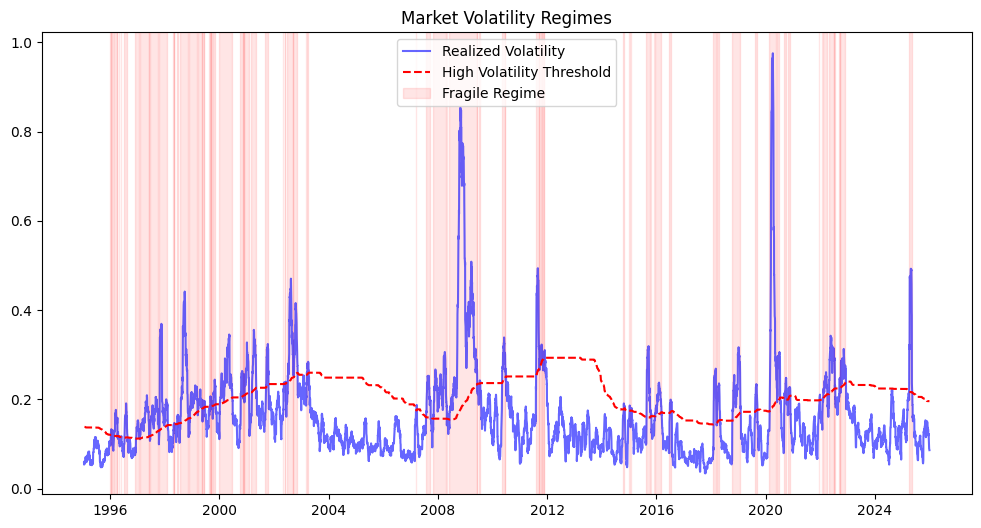

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(regime_df.index, regime_df['Realized_Vol'], label='Realized Volatility', color='blue', alpha=0.6)
plt.plot(regime_df.index, regime_df['Vol_High_Threshold'], label='High Volatility Threshold', color='red', linestyle='--')
plt.fill_between(regime_df.index, 0, 1, where=regime_df['Target_Regime_5d']==1, color='red', alpha=0.1, transform=plt.gca().get_xaxis_transform(), label='Fragile Regime')
plt.title('Market Volatility Regimes')
plt.legend()
plt.show()

<Axes: xlabel='Target_Regime_5d'>

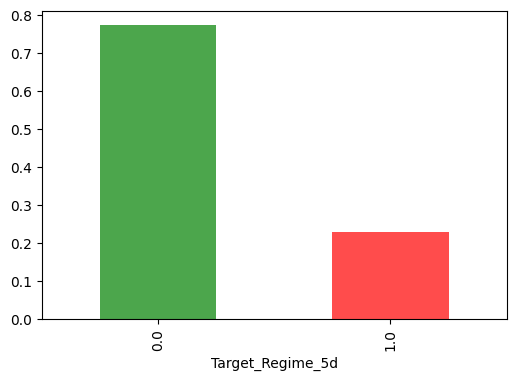

In [10]:
plt.figure(figsize=(6, 4))
df['Target_Regime_5d'].value_counts(normalize=True).plot(
    kind='bar', color=['green', 'red'], alpha=0.7
)

<Axes: xlabel='Bull_Bear_Regime'>

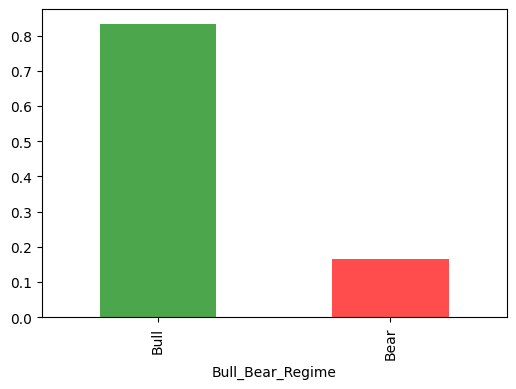

In [11]:
plt.figure(figsize=(6, 4))
df['Bull_Bear_Regime'].value_counts(normalize=True).plot(
    kind='bar', color=['green', 'red'], alpha=0.7
)

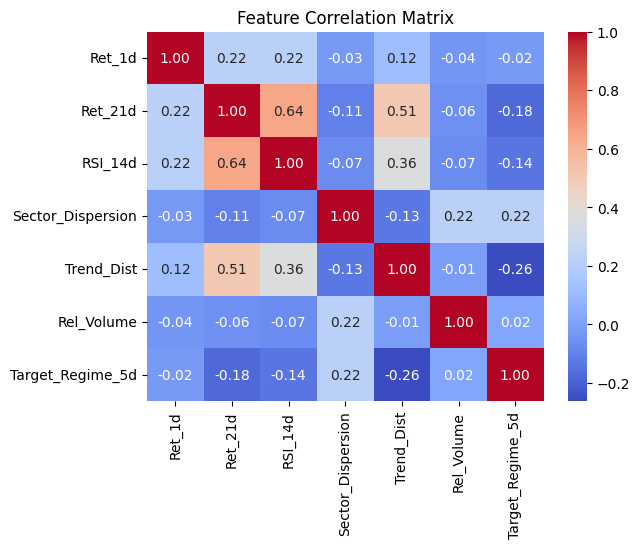

In [12]:
corr_matrix = df[feature_cols + ['Target_Regime_5d']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

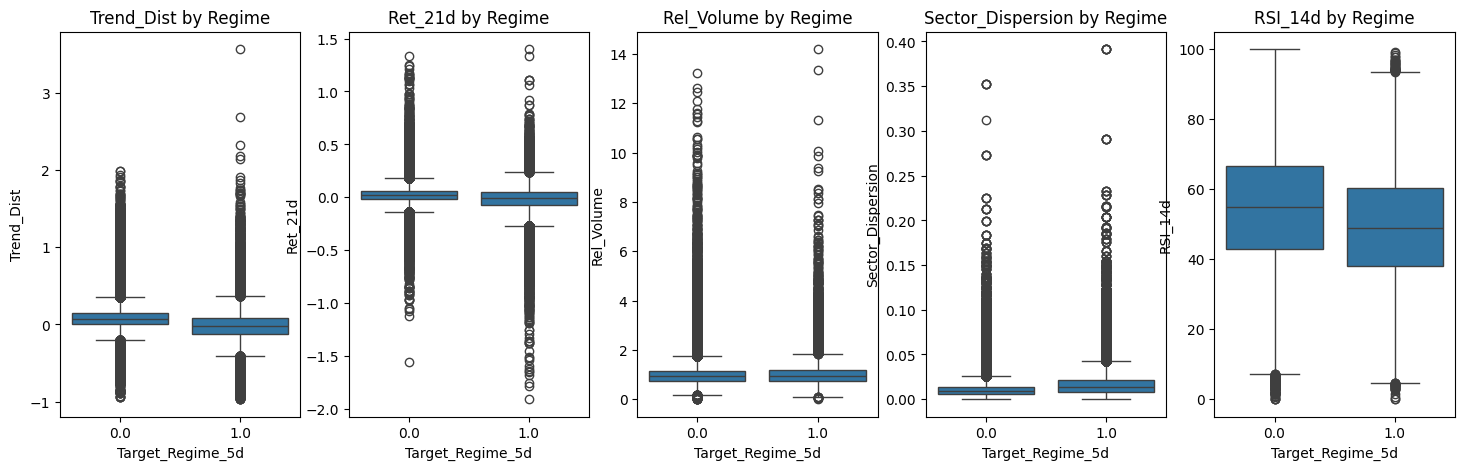

In [13]:
features_to_plot = ['Trend_Dist', 'Ret_21d', 'Rel_Volume', 'Sector_Dispersion', 'RSI_14d']
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for i, col in enumerate(features_to_plot):
    sns.boxplot(x='Target_Regime_5d', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Regime')

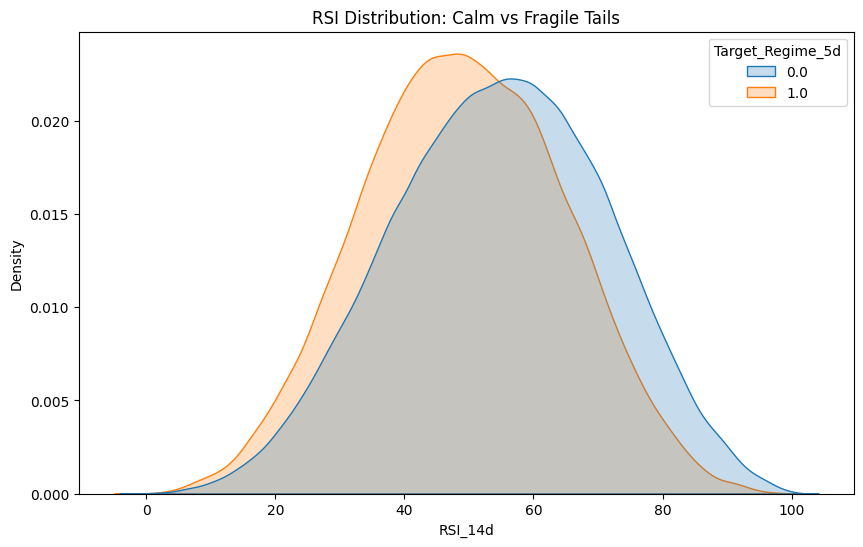

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='RSI_14d', hue='Target_Regime_5d', fill=True, common_norm=False)
plt.title('RSI Distribution: Calm vs Fragile Tails')
plt.show()

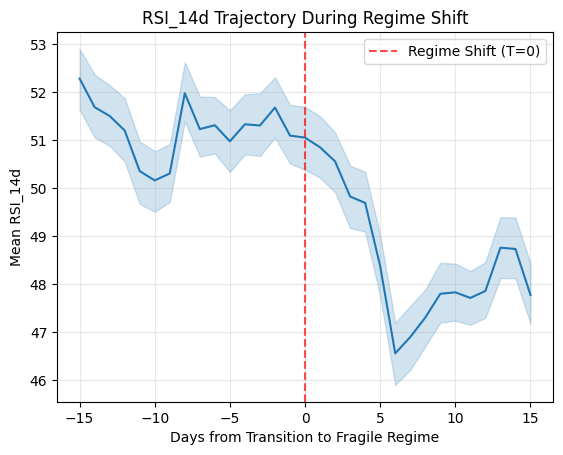

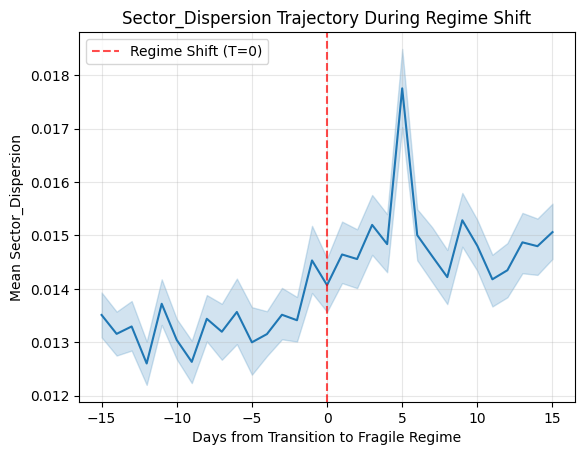

In [15]:
def plot_shift_trajectory(df, feature_name, window=15):

    regime_series = df.groupby('Date')['Target_Regime_5d'].first()
    transitions = regime_series[(regime_series.shift(1) == 0) & (regime_series == 1)].index
    
    event_windows = []
    all_dates = regime_series.index
    
    for event_date in transitions:
        idx = all_dates.get_loc(event_date)
            
        window_dates = all_dates[idx - window : idx + window + 1]
        rel_time = np.arange(-window, window + 1)
        
        subset = df[df['Date'].isin(window_dates)].copy()
        date_map = dict(zip(window_dates, rel_time))
        subset['T'] = subset['Date'].map(date_map)
        
        event_windows.append(subset[['T', feature_name]])

    plot_df = pd.concat(event_windows)

    sns.lineplot(data=plot_df, x='T', y=feature_name, errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Regime Shift (T=0)')
    plt.title(f'{feature_name} Trajectory During Regime Shift')
    plt.xlabel('Days from Transition to Fragile Regime')
    plt.ylabel(f'Mean {feature_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_shift_trajectory(full_df, 'RSI_14d')
plot_shift_trajectory(full_df, 'Sector_Dispersion')